In [1]:
# Check current versions
!python -c "import numpy; print('Current numpy version:', numpy.__version__)"
!python -c "import torch; print('Current torch version:', torch.__version__)"

# Install desired versions with CUDA 12.4
!pip install numpy==1.26.4
!pip install torch==2.3.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu124.html
!pip install torcheeg
!pip install pytorch-lightning

# This will show the versions in new Python processes
!python -c "import numpy; print('Installed numpy version:', numpy.__version__)"
!python -c "import torch; print('Installed torch version:', torch.__version__)"

print("\n*** IMPORTANT: Please restart the runtime now for changes to take effect in this notebook  (search for 'restart session' in top left 'commands' ***")

Current numpy version: 2.0.2
Current torch version: 2.6.0+cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 67.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==2.3.0+cu124 (from versions: 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    accelerator = "gpu"
    pin_memory = True
    print("GPU is available. Training will use GPU acceleration.")
else:
    accelerator = "cpu"
    pin_memory = False
    print("WARNING: GPU not available, using CPU instead")

PyTorch version: 2.6.0+cu124
CUDA version: 12.4


In [ ]:
import os
from google.colab import drive
from IPython.display import clear_output as cls

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
experiment_name = input("name your experiment (or use old one) > ")  # like lstm_00

IO_PATH = f'/content/drive/MyDrive/datasets/STEW/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'/content/drive/MyDrive/datasets/STEW/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = '/content/drive/MyDrive/datasets/STEW/dataset' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")


SEED:int = 42
BATCH_SIZE:int = 64
N_WORKERS:int = 2

ATTENTION: model folder already exists, only proceed if you are ready to overwrite


# loading data

In [ ]:
"""
should take about a minute
"""

import os
import numpy as np
import mne
from typing import List, Dict


def load_stew_dataset(stew_path: str) -> tuple:
    subjects = set()
    for filename in os.listdir(stew_path):
        if filename.startswith('sub') and filename.endswith('.txt'):
            try:
                subject_id = int(filename[3:5])
                subjects.add(subject_id)
            except ValueError:
                continue
    subjects = sorted(list(subjects))


    raw_list = []
    info_list = []
    task_mapping = {'lo': 'low','hi': 'high'}

    ch_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] # correct channel names in order
    sfreq = 128 # assume sampling rate in hZ
    montage = mne.channels.make_standard_montage("standard_1020")


    for subject in subjects:
        subject_str = f"{subject:02d}" # leading zero if needed

        for task_code in ['lo', 'hi']:
            filename = f"sub{subject_str}_{task_code}.txt"
            file_path = os.path.join(stew_path, filename)

            if os.path.exists(file_path):
                eeg_data = np.loadtxt(file_path)

                info = mne.create_info(
                    ch_names=ch_names,
                    sfreq=sfreq,
                    ch_types=['eeg'] * len(ch_names)
                )

                raw = mne.io.RawArray(eeg_data.T, info)
                raw.set_montage(montage)
                raw.filter(0.5, 45)
                raw.notch_filter(50)

                metadata = {
                    'subject_id': subject,
                    'trial_id': task_code,
                    'workload_level': 0 if task_code == 'lo' else 1 # true if doing task (thus high cogload)
                }

                raw_list.append(raw)
                info_list.append(metadata)

    return raw_list, info_list


def split_raw_object(raw, clip_duration:int):
    sfreq = raw.info['sfreq']
    samples_per_clip = int(clip_duration * sfreq)

    n_samples = len(raw.times)
    n_clips = n_samples // samples_per_clip

    raw_clips = []

    for i in range(n_clips):
        start_sample = i * samples_per_clip
        end_sample = start_sample + samples_per_clip

        clip = raw.copy().crop(
            tmin=start_sample / sfreq,
            tmax=(end_sample - 1) / sfreq,
            include_tmax=True
        )

        raw_clips.append(clip)

    return raw_clips


WINDOW_SIZE = 4 # seconds

unsplit_raw_list, unsplit_info_list = load_stew_dataset(DATA_FOLDER_PATH)
raw_list = []
info_list = []


for raw, info in zip(unsplit_raw_list, unsplit_info_list):
    raws = split_raw_object(raw, WINDOW_SIZE)
    raw_list.extend(raws)
    info_list.extend([info] * len(raws))


cls()
print(f"\n\nLoaded {len(unsplit_raw_list)} recordings,  split into {len(raw_list)} clips of {str(WINDOW_SIZE)} seconds, from {len(set([info['subject_id'] for info in info_list]))} subjects")
del unsplit_raw_list
del unsplit_info_list


import random
raw = random.choice(raw_list)



Loaded 96 recordings,  split into 3552 clips of 4 seconds, from 48 subjects


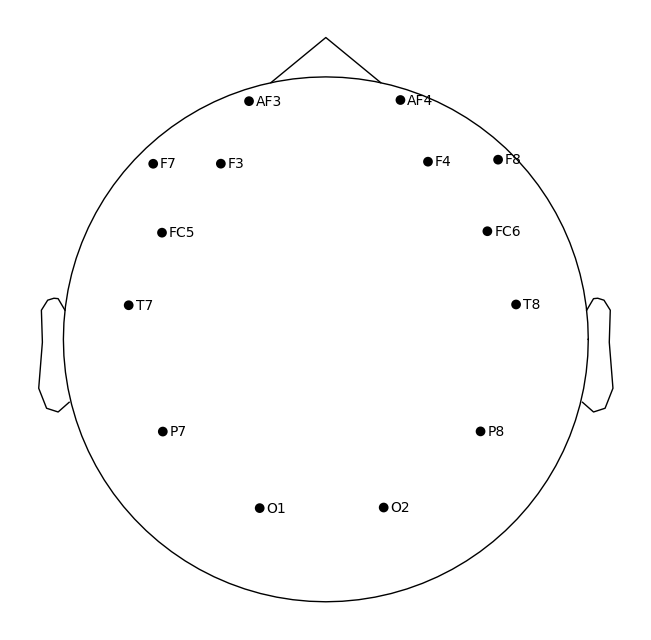

{'AF3': (-0.035186007467538326, 0.10912956509481905), 'F7': (-0.07187662505917264, 0.07310352742670875), 'F3': (-0.05180903841183724, 0.08668789888287941), 'FC5': (-0.07890597635539306, 0.05136738419239063), 'T7': (-0.08598207795805729, 0.014871638175652204), 'P7': (-0.07445796452347851, -0.042123164958505765), 'O1': (-0.03157355787465608, -0.08056835212663661), 'O2': (0.027683100559624117, -0.08048883980936473), 'P8': (0.07103247088902218, -0.04225997601209522), 'T8': (0.08326136985759491, 0.015258189278681372), 'FC6': (0.0778466192866476, 0.052098811200362666), 'F4': (0.050274277731628736, 0.08743838910239796), 'F8': (0.07143526925150917, 0.07450512647808137), 'AF4': (0.0342298581732583, 0.10981127208682755)}


In [ ]:
def get_channel_locations_from_mne(raw):
    """
    make sure montage is set
    """

    pos_3d = raw.get_montage().get_positions()['ch_pos']
    ch_names = raw.ch_names

    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


# fig_topo = raw.plot_sensors(show_names=True)
STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)
CHANNEL_NAMES = list(STEW_CHANNEL_LOCATION_DICT.keys())
print(STEW_CHANNEL_LOCATION_DICT)

### fancy graphs for testing

Using matplotlib as 2D backend.


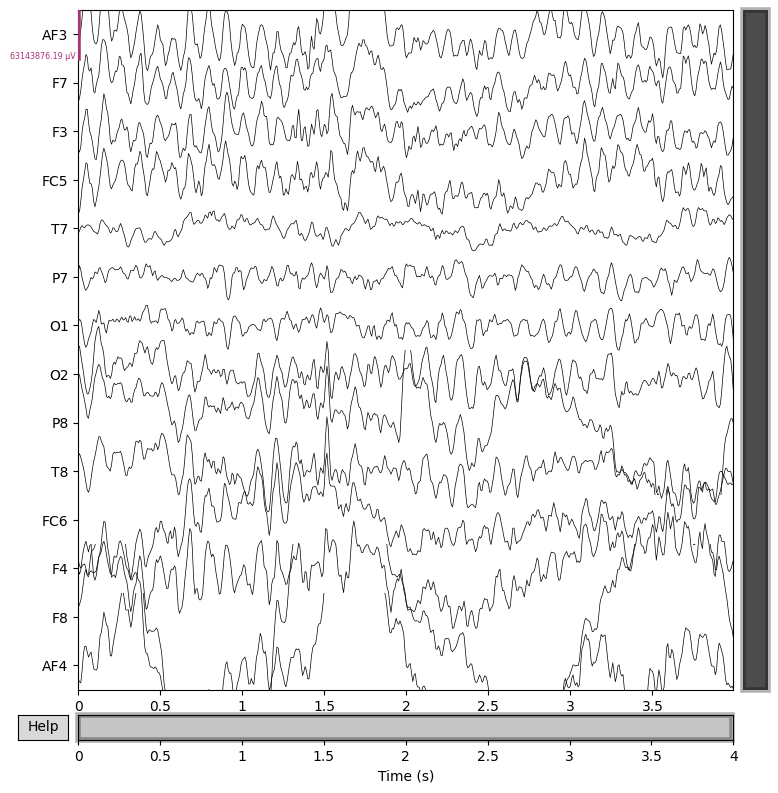

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.000 (s)
Plotting power spectral density (dB=True).


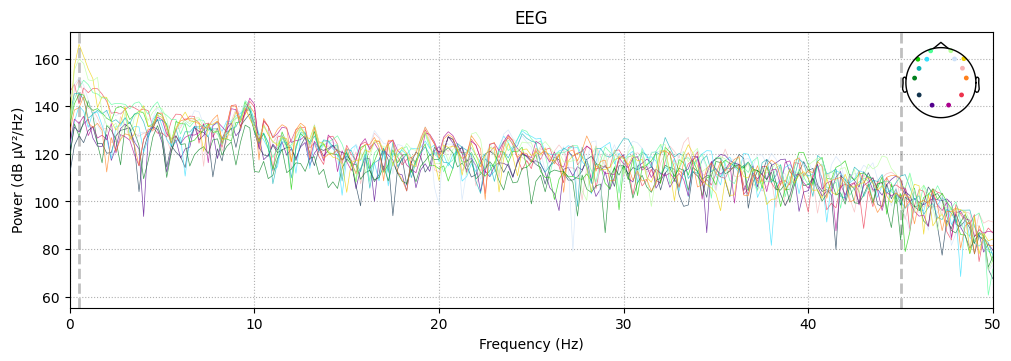

In [ ]:
# import matplotlib.pyplot as plt

# # plot raw graph
# fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# # plot power spectral density
# fig_psd = raw.plot_psd(fmax=50)

(129, 13)


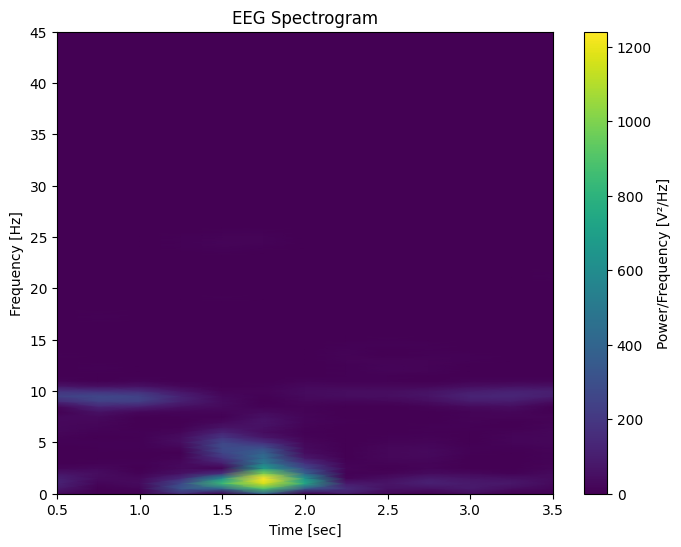

In [ ]:
# from scipy import signal

# def create_spectogram(raw_data):
#     f, t, Sxx = signal.spectrogram(
#         raw_data,
#         fs=128,              # Sampling rate
#         nperseg=128,         # Window size (1 second at 128 Hz)
#         noverlap=96,         # 75% overlap
#         nfft=256,            # Length of FFT
#         detrend='constant',  # Remove mean from each segment
#         window='hann'        # Apply Hann window to reduce spectral leakage
#     )
#     return f, t, Sxx

# def plot_spectogram(f, t, Sxx):
#     plt.figure(figsize=(8, 6))
#     plt.pcolormesh(t, f, Sxx, shading='gouraud', cmap='viridis')
#     plt.ylabel('Frequency [Hz]')
#     plt.xlabel('Time [sec]')
#     plt.title('EEG Spectrogram')
#     plt.colorbar(label='Power/Frequency [V²/Hz]')
#     plt.ylim(0, 45)  # Limit to frequencies below 45 Hz
#     plt.show()

# raw_data = raw.get_data()[0] # first channel AF3
# f, t, Sxx = create_spectogram(raw_data)
# print(Sxx.shape)
# plot_spectogram(f, t, Sxx)

# DL using torcheeg

In [ ]:
from torcheeg import transforms

FREQUENCY_BINS = 64
N_CHANNELS = len(CHANNEL_NAMES)

# our chunks are already put into 4s windows, so no need for `MapChunk`
# (paper contradicts itselft) having our normalization after the freq-extraction, normalizes each frequency by itself
# this here uses Wavelet-Tranform instead of Short-Fourier-Transform
offline_transform = transforms.Compose([
    transforms.CWTSpectrum(
        wavelet='morl',
        total_scale=FREQUENCY_BINS,
        contourf=False
    ),
    transforms.MeanStdNormalize(),
])

processed_raw = offline_transform(eeg=raw.get_data())
print(processed_raw["eeg"].shape)  # should be [channels, frequency_bins, sample_rate x clip_length] (will add batch_size in pipeline) -

(14, 64, 512)


In [ ]:
from torcheeg.datasets import MNERawDataset
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from typing import Tuple


online_transform = transforms.Compose([
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Select('workload_level')
])

dataset = MNERawDataset(
    io_path=IO_PATH,

    raw_list=raw_list,
    info_list=info_list,
    chunk_size=512,  # 4 seconds at 128 Hz (better for cognitive load)
    overlap=320,     # 74% overlap

    offline_transform=offline_transform,
    online_transform=online_transform,
    label_transform=label_transform,

    num_worker=0, # don't multiprocess to avoid serialization problem
    verbose=False
)

# ---
print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
eeg_data, label = sample

print(f"EEG data shape: {eeg_data.shape}")
print(f"Label: {label}")

[2025-05-01 12:55:45] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from /content/drive/MyDrive/datasets/STEW/io/lstm_00/.
INFO:torcheeg:🔍 | Detected cached processing results, reading cache from /content/drive/MyDrive/datasets/STEW/io/lstm_00/.


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader, random_split

# validation is used during training for evaluating each batch
# test is saved to after (even if we don't train on val anyway, mechanisms like picking the best may still have 'val bias')
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")


# ---
# when training a GPU, we put the memory on a special 'pinned' region for faster transfer between CPU and GPU
# we shuffle the data in training to avoid it learning some patterns there (across batches) - no need on eval, since metrics will be the same
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

# ---
for batch in train_loader:
    # Unpack the batch
    X, y = batch

    # Print shapes
    print(f"Input tensor shape: {X.shape}")
    print(f"Label tensor shape: {y.shape}")

    # Print label distribution
    unique_labels, counts = torch.unique(y, return_counts=True)
    print("Label distribution:")
    for label, count in zip(unique_labels.tolist(), counts.tolist()):
        print(f"  Class {label}: {count} samples ({count/len(y)*100:.2f}%)")

    # Print some additional statistics about the input data
    print(f"Input data statistics:")
    print(f"  Min value: {X.min().item():.4f}")
    print(f"  Max value: {X.max().item():.4f}")
    print(f"  Mean value: {X.mean().item():.4f}")
    print(f"  Std deviation: {X.std().item():.4f}")

    break

### initializing model

In [ ]:
from torch import nn

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, num_classes=2):
        super(BiLSTMModel, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers


        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)


    def forward(self, x):
        # x shape: [batch, channels, freq_bins, time_bins]
        batch_size, channels, freq_bins, time_bins = x.shape

        # Reshape for LSTM - each time step contains all frequency data for all channels
        x_reshaped = x.permute(0, 3, 1, 2).reshape(batch_size, time_bins, channels * freq_bins)

        # Forward pass through LSTM
        lstm_out, _ = self.lstm(x_reshaped)

        # Use the output from the last time step
        out = self.fc(lstm_out[:, -1, :])
        return out


N_CLASSES:int = 2 # depends on your dataset, duh?

model = BiLSTMModel(
    input_size=896, #
    num_classes=N_CLASSES
)

### actual training (don't run for inference only)

In [ ]:
from torcheeg.trainers import ClassifierTrainer

trainer = ClassifierTrainer(
    model=model,
    num_classes=N_CLASSES,
    lr=5e-5,
    weight_decay=1e-4,
    accelerator=accelerator,
    metrics=["accuracy", "precision", "recall", "f1score"],
)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    # saves the best model (for recalling after plateu)
    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='best-model-{epoch:02d}-{val_accuracy:.4f}',
        monitor='val_accuracy',
        mode='max',
        save_top_k=1
    ),

    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='last-model',
        save_last=True
    ),

    # detect overfitting and end if val_accuracy stops improving for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=True
    )
]

trainer.fit(
    train_loader,
    val_loader,
    max_epochs=100,
    default_root_dir=MODEL_SAVE_PATH,
    callbacks=callbacks,
    enable_progress_bar=True,
    enable_model_summary=True
)

# ends once the trainer is done (so most likely through EarlyStop, otherwise max_epochs)

In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.test(test_loader)[0]
print(test_results)
print(f"Test accuracy: {test_results['test_accuracy']:.4f}")

In [ ]:
!reload_ext tensorboard
!tensorboard --logdir=/content/drive/MyDrive/datasets/STEW/io/lstm_00/model/lightning_logs/

# loading model and doing inference

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os

for fname in os.listdir(MODEL_SAVE_PATH):
    if fname.startswith("best-model") and fname.endswith(".ckpt"):
        break


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# continuing code will fail if for some reason there is no file called best-model-...ckpt
# (is automatically created due to our callbacks in training)
ckpt_path = MODEL_SAVE_PATH + fname

print(f"Loading {ckpt_path}")
checkpoint = torch.load(
    ckpt_path,
    map_location=device
)


if 'state_dict' in checkpoint:
    state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
else:
    model.load_state_dict(checkpoint)

In [ ]:
for batch in train_loader:
    dummy_input = batch[0][0:2] # take small batch of two (so the dynamic batching will work)
    print(dummy_input.shape) # torch.Size([2, 36, 16, 16])
    break



onnx_path = MODEL_SAVE_PATH + "inference.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["eeg_input"],
    output_names=["class_probabilities"],
    dynamic_axes={
        "eeg_input": {0: "batch_size"},
        "class_probabilities": {0: "batch_size"}
    }
)

In [ ]:
#
# loading model and doing inference to check if this works
#
import onnxruntime as ort
import numpy as np


session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # fallbacks to CPU if CUDA isn't available


session = ort.InferenceSession(
    onnx_path,
    sess_options=session_options,
    providers=providers
)


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


# numpy is more efficient that tensors, and in inference we don't need AutoGrad features
test_batch = next(iter(test_loader))
test_data, test_labels = test_batch[0], test_batch[1]
test_data_np = test_data.numpy()


onnx_outputs = session.run([output_name], {input_name: test_data_np})
probabilities = onnx_outputs[0]
predicted_classes = np.argmax(probabilities, axis=1)
print(predicted_classes)